<a href="https://colab.research.google.com/github/MinYeongPark/AI_practice/blob/main/2_Alexnet_and_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet

In [ ]:
# 런타임 - 런타임 유형 변경 - GPU로 변경하기
import torch

device = torch.device('cuda')
torch.cuda.is_available() # GPU를 쓸 수 있는지

True

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

fasion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224)
])

# 1*28*28 -> 1*227*227

download_root = './'

train_dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)
test_dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=False, download=True)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

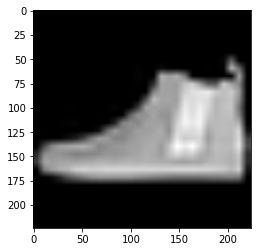

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[23744][0][0].numpy(), cmap='gray')

In [ ]:
from torch import nn

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=48, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),

            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),

            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.FC = nn.Sequential(
            nn.Linear(128*6*6, 2048), 
            nn.ReLU(True),
            nn.Dropout(0.5), # 학습할 때 절반정도는 날리고 학습하겠다는 뜻

            nn.Linear(2048, 2048), 
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(2048, 10), 
            nn.Softmax()
        )

    def forward(self, inp):
        cnn_res = self.CNN(inp)
        # flatten 128*6*6 -> 00000 (한 줄로 나열)
        flatten = torch.flatten(cnn_res, 1)
        fc_res = self.FC(flatten)
        return fc_res

In [ ]:
from torch import optim

def train(model, epochs) :

    # optimizer 설정
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # loss function
    criterion = nn.CrossEntropyLoss() # classification 분류 

    for epoch in range(epochs) : 
        model.train() # model을 train상태로
        train_accuracy = 0.0

        for batch_ind, samples in enumerate(train_loader):
            x_t, y_t = samples # x는 입력, y는 출력(정답)
            # device로 x_t, y_t 보냄
            x_t, y_t = x_t.to(device), y_t.to(device)

            # x_t 넣어서 predicted
            pred = model(x_t)
            
            # predicted랑 y_t 비교
            # 둘의 차이 = loss 계산
            loss = criterion(pred, y_t)

            # loss 값을 가지고 back-propagation weight를 업데이트
            # optimizer가 해줍니다
            optimizer.zero_grad() # 초기화
            loss.backward()
            optimizer.step()

        # accuracy test form train dataset
        model.eval() # model을 평가상태로 만듦
        correct = 0
        for xx, yy in train_loader:
            data, target = xx.to(device), yy.to(device)
            pred = model(data) # pred [0, 0, 0.1, 0.2, 0.1 .. 0] 합이 1
            _, predicted = torch.max(pred, 1) # 높은 것 하나를 뽑아낸다
            correct += predicted.eq(target.data).sum()

        print("train accuracy : ", (100. * correct / len(train_loader.dataset)).item())

train(model, 30) -> 알아서 학습

In [ ]:
alexnet = AlexNet()
alexnet.to(device)
train(alexnet, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train accuracy :  72.30166625976562
train accuracy :  76.37667083740234
train accuracy :  78.19833374023438
train accuracy :  80.08499908447266
train accuracy :  80.66166687011719
train accuracy :  81.24166870117188
train accuracy :  81.79000091552734
train accuracy :  82.21666717529297
train accuracy :  88.39666748046875
train accuracy :  89.45333099365234


In [ ]:
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

In [ ]:
get_n_params(alexnet) # 몇개의 파라미터가 있는지 확인

14590314

In [ ]:
alexnet.eval() #  model을 평가상태로 만듦
correct = 0
for xx, yy in train_loader:
    data, target = xx.to(device), yy.to(device)
    pred = alexnet(data) # pred [0, 0, 0.1, 0.2, 0.1 .. 0] 합이 1
    _, predicted = torch.max(pred, 1) # 높은 것 하나를 뽑아낸다
    correct += predicted.eq(target.data).sum()

print("train accuracy : ", (100. * correct / len(train_loader.dataset)).item())

train accuracy :  89.45333099365234


In [ ]:
alexnet

AlexNet(
  (CNN): Sequential(
    (0): Conv2d(1, 48, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (11): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (14): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): LocalResponseNorm(5, alpha=0.0001, beta

# Convolution layer를 증가시키면 성능이 증가하는가?

In [ ]:
# Fasion MNIST

class Anet(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN
        self.CNN = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # FC (Fully Connected)
        self.FC = nn.Sequential(
            nn.Linear(64*29*29, 256),
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(256, 64), 
            nn.ReLU(True),
            nn.Dropout(0.2),

            nn.Linear(64, 10), 
            nn.Softmax()
        )

    def forward(self, inp):
        cnn_res = self.CNN(inp)
        flatten = torch.flatten(cnn_res, 1)
        fc_res = self.FC(flatten)
        return fc_res
    

In [ ]:
aaa = Anet()

In [ ]:
get_n_params(aaa)

13872250

In [ ]:
aaa.to(device)
train(aaa, 10)

train accuracy :  78.57833099365234
train accuracy :  81.30500030517578
train accuracy :  83.08000183105469
train accuracy :  83.19667053222656
train accuracy :  84.16333770751953
train accuracy :  87.14500427246094
train accuracy :  88.42500305175781
train accuracy :  88.80333709716797
train accuracy :  89.29499816894531
train accuracy :  89.74500274658203
